# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [58]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

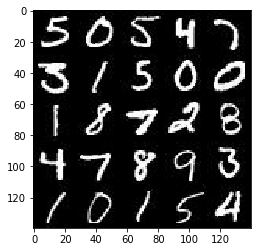

In [59]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

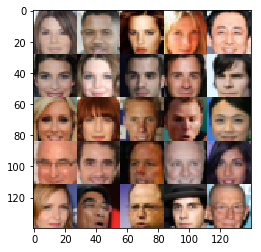

In [60]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [62]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32,(None,image_height,image_width,image_channels),name="input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name="input_z")
    learning_rate_pl =tf.placeholder(tf.float32,name="learning_rate")
    return input_real,input_z,learning_rate_pl




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [63]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.10 #TODO: Check
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2,  training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3,  training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
   
        conv4 = tf.layers.conv2d(conv3, 512, 5, strides=1, padding='same')
        conv4 = tf.layers.batch_normalization(conv3,  training=True)
        conv4 = tf.maximum(alpha * conv3, conv3)

        flat  = tf.reshape(conv4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 #TODO:
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=1, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
       
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding="same")
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
                
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [65]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #TODO:??
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(
             logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [66]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #TODO:??
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
                  learning_rate, beta1=beta1).minimize(
                  d_loss, var_list=d_vars)
    with tf.control_dependencies(
         tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(
                      learning_rate, beta1=beta1).minimize(
                      g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [77]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 100 #TODO:
    print_every = 100
    

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                steps += 1               
                
         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

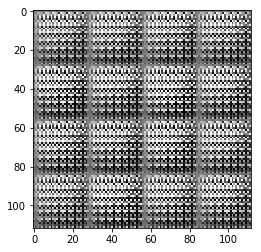

Epoch 0/2... Discriminator Loss: 5.8722... Generator Loss: 0.0100


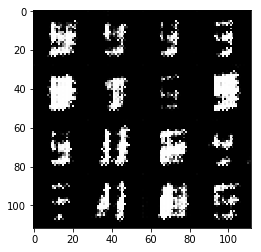

Epoch 0/2... Discriminator Loss: 1.7652... Generator Loss: 0.3876


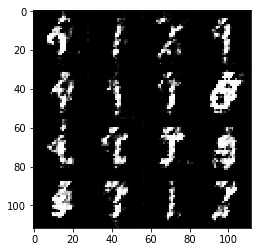

Epoch 0/2... Discriminator Loss: 1.1299... Generator Loss: 0.7140


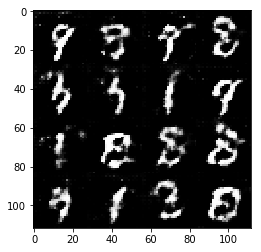

Epoch 0/2... Discriminator Loss: 1.5348... Generator Loss: 0.5843


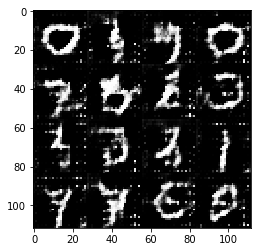

Epoch 0/2... Discriminator Loss: 1.7709... Generator Loss: 0.5768


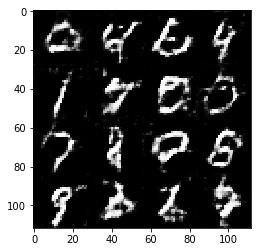

Epoch 0/2... Discriminator Loss: 1.4595... Generator Loss: 0.6161


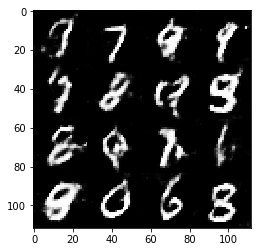

Epoch 0/2... Discriminator Loss: 1.3118... Generator Loss: 0.6082


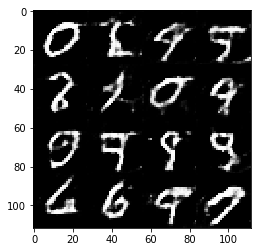

Epoch 0/2... Discriminator Loss: 1.3442... Generator Loss: 0.7767


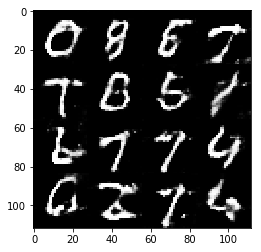

Epoch 0/2... Discriminator Loss: 1.4613... Generator Loss: 0.6902


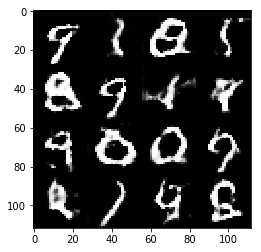

Epoch 0/2... Discriminator Loss: 1.1618... Generator Loss: 0.8434


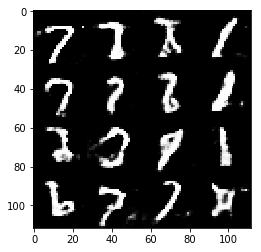

Epoch 0/2... Discriminator Loss: 1.5055... Generator Loss: 1.4437


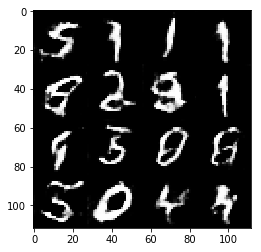

Epoch 0/2... Discriminator Loss: 1.7123... Generator Loss: 0.3781


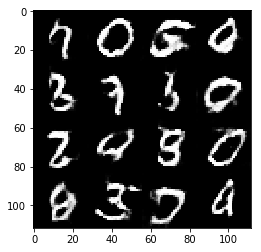

Epoch 0/2... Discriminator Loss: 1.4262... Generator Loss: 0.5334


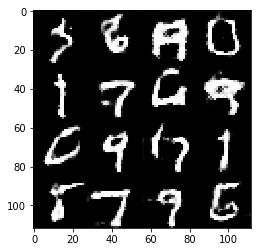

Epoch 0/2... Discriminator Loss: 1.1476... Generator Loss: 0.7834


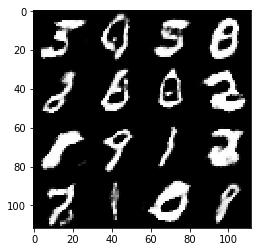

Epoch 0/2... Discriminator Loss: 0.8471... Generator Loss: 1.9112


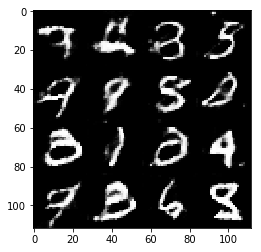

Epoch 0/2... Discriminator Loss: 1.5640... Generator Loss: 0.4283


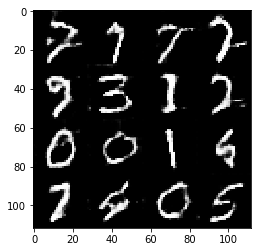

Epoch 0/2... Discriminator Loss: 1.6180... Generator Loss: 0.5104


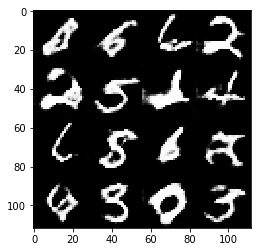

Epoch 0/2... Discriminator Loss: 1.1986... Generator Loss: 0.7228


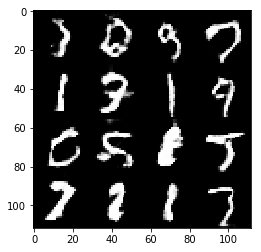

Epoch 0/2... Discriminator Loss: 1.0680... Generator Loss: 0.8439


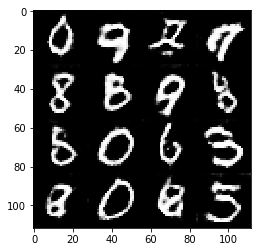

Epoch 0/2... Discriminator Loss: 1.3693... Generator Loss: 0.6017


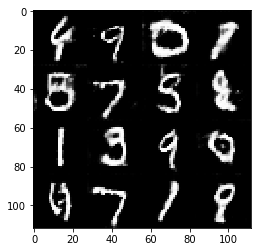

Epoch 0/2... Discriminator Loss: 2.3494... Generator Loss: 0.1959


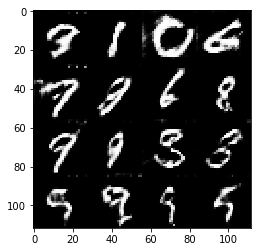

Epoch 0/2... Discriminator Loss: 1.6353... Generator Loss: 0.3556


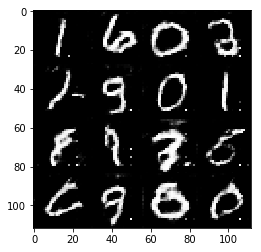

Epoch 0/2... Discriminator Loss: 3.1260... Generator Loss: 0.0807


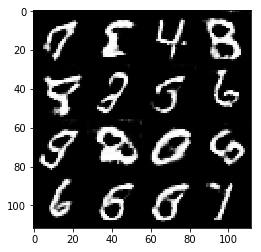

Epoch 0/2... Discriminator Loss: 2.4906... Generator Loss: 0.1513


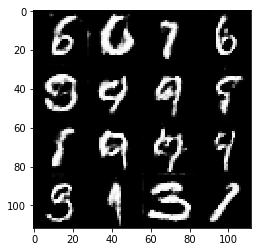

Epoch 0/2... Discriminator Loss: 1.2752... Generator Loss: 0.5976


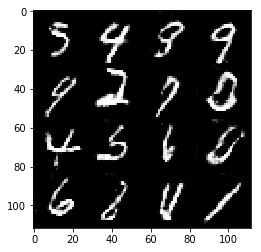

Epoch 0/2... Discriminator Loss: 1.7752... Generator Loss: 0.3460


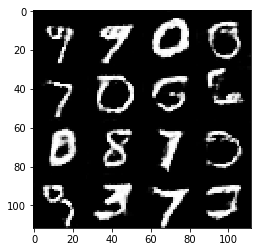

Epoch 0/2... Discriminator Loss: 1.2447... Generator Loss: 0.6553


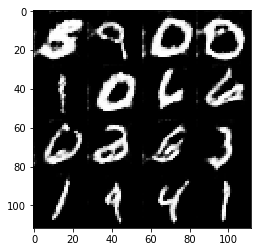

Epoch 0/2... Discriminator Loss: 2.1363... Generator Loss: 0.2885


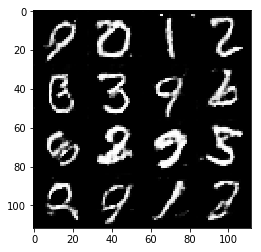

Epoch 0/2... Discriminator Loss: 1.2889... Generator Loss: 0.6894


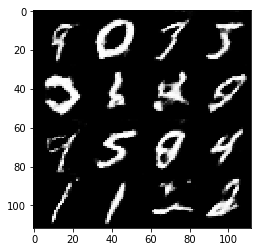

Epoch 0/2... Discriminator Loss: 0.7188... Generator Loss: 1.3323


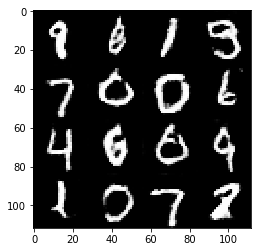

Epoch 0/2... Discriminator Loss: 0.7736... Generator Loss: 1.2429


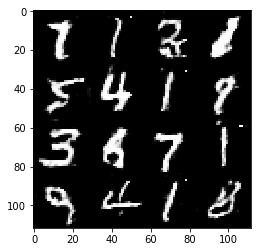

Epoch 0/2... Discriminator Loss: 2.7995... Generator Loss: 0.1180


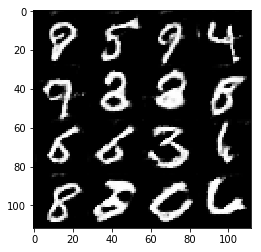

Epoch 0/2... Discriminator Loss: 1.2244... Generator Loss: 0.6542


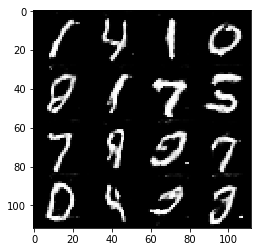

Epoch 0/2... Discriminator Loss: 2.0428... Generator Loss: 0.2633


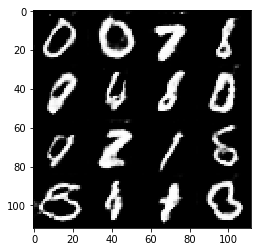

Epoch 0/2... Discriminator Loss: 2.1991... Generator Loss: 0.2778


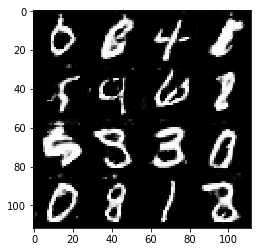

Epoch 0/2... Discriminator Loss: 1.2061... Generator Loss: 0.6413


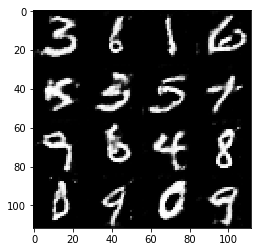

Epoch 0/2... Discriminator Loss: 0.9082... Generator Loss: 0.9867


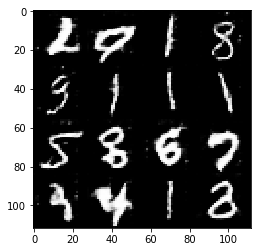

Epoch 0/2... Discriminator Loss: 1.2185... Generator Loss: 0.6155


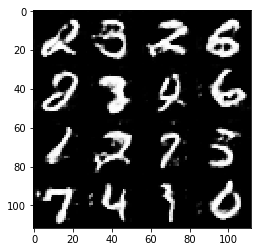

Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 0.9792


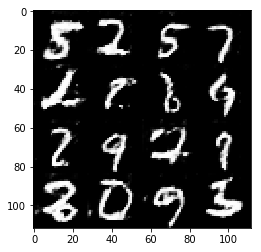

Epoch 1/2... Discriminator Loss: 1.6091... Generator Loss: 0.3801


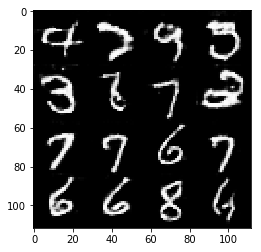

Epoch 1/2... Discriminator Loss: 1.7990... Generator Loss: 0.3558


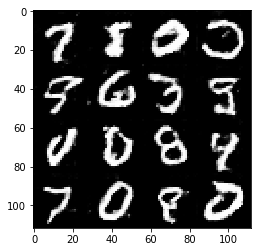

Epoch 1/2... Discriminator Loss: 1.6331... Generator Loss: 0.3947


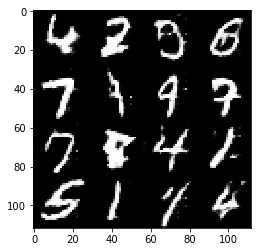

Epoch 1/2... Discriminator Loss: 2.9507... Generator Loss: 0.1354


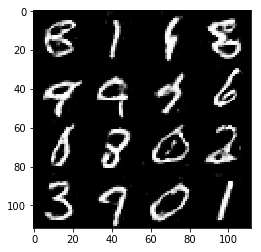

Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 0.3735


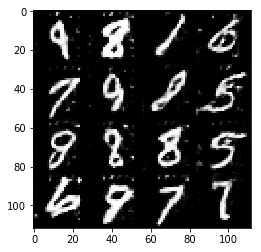

Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 0.7871


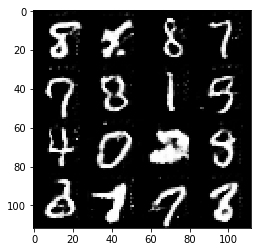

Epoch 1/2... Discriminator Loss: 1.9671... Generator Loss: 0.2599


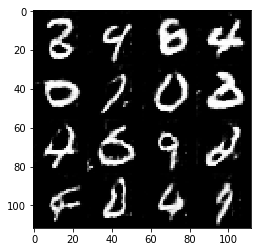

Epoch 1/2... Discriminator Loss: 1.6923... Generator Loss: 0.3806


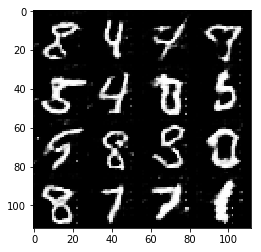

Epoch 1/2... Discriminator Loss: 2.3478... Generator Loss: 0.2804


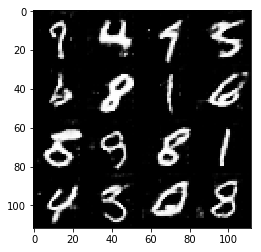

Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.6520


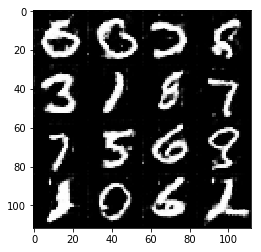

Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 1.5313


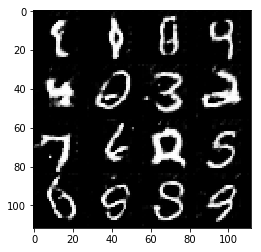

Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.5748


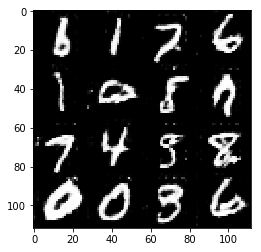

Epoch 1/2... Discriminator Loss: 2.2614... Generator Loss: 0.2555


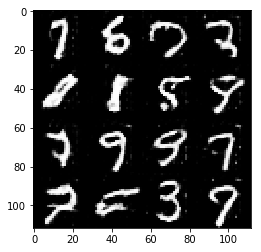

Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.4149


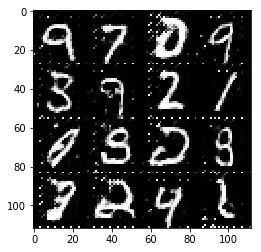

Epoch 1/2... Discriminator Loss: 1.8148... Generator Loss: 0.3224


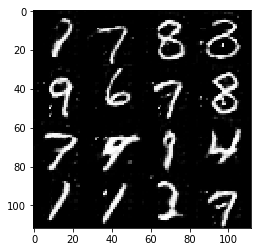

Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.4900


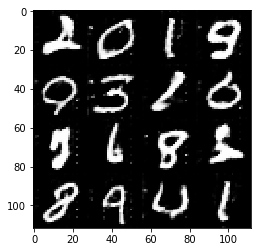

Epoch 1/2... Discriminator Loss: 1.6270... Generator Loss: 0.4658


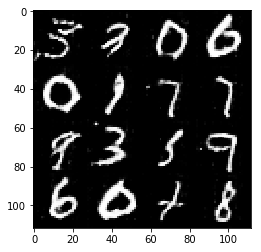

Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.8771


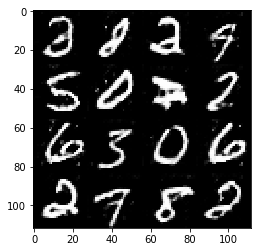

Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.3708


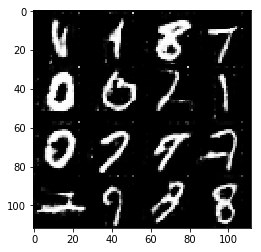

Epoch 1/2... Discriminator Loss: 1.7130... Generator Loss: 0.3868


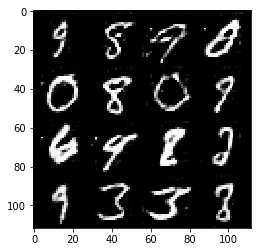

Epoch 1/2... Discriminator Loss: 2.0082... Generator Loss: 0.2787


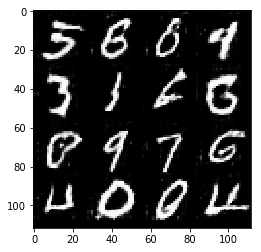

Epoch 1/2... Discriminator Loss: 1.5894... Generator Loss: 0.5102


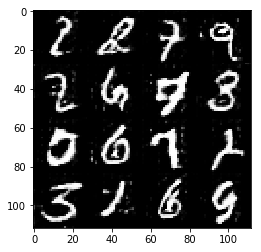

Epoch 1/2... Discriminator Loss: 2.8756... Generator Loss: 0.1141


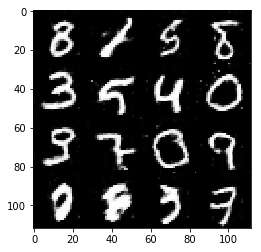

Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.8034


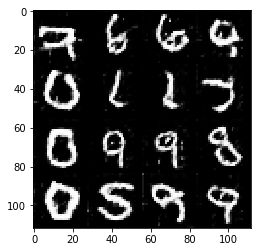

Epoch 1/2... Discriminator Loss: 1.5739... Generator Loss: 0.5991


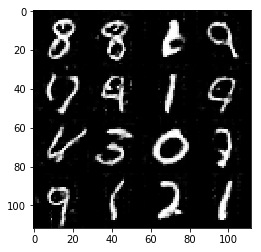

Epoch 1/2... Discriminator Loss: 2.3052... Generator Loss: 0.1874


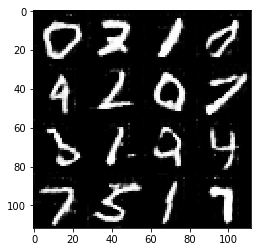

Epoch 1/2... Discriminator Loss: 2.2238... Generator Loss: 0.2733


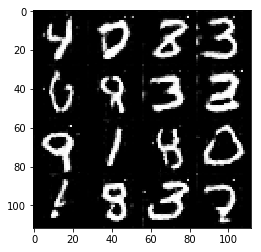

Epoch 1/2... Discriminator Loss: 2.8087... Generator Loss: 0.1216


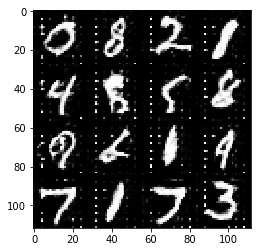

Epoch 1/2... Discriminator Loss: 1.5468... Generator Loss: 0.4219


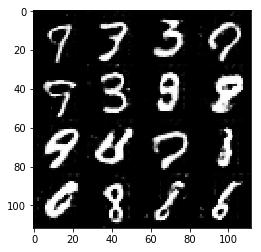

Epoch 1/2... Discriminator Loss: 2.4382... Generator Loss: 0.2345


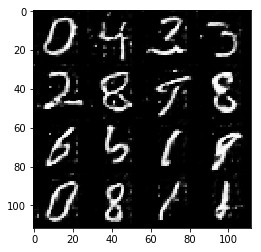

Epoch 1/2... Discriminator Loss: 2.1549... Generator Loss: 0.2493


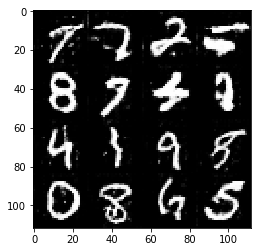

Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.7804


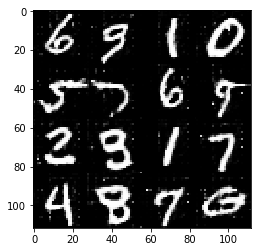

Epoch 1/2... Discriminator Loss: 1.9106... Generator Loss: 0.3682


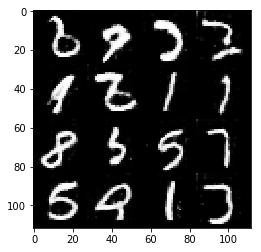

Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.6402


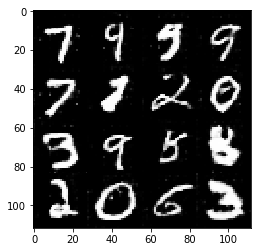

Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 1.3054


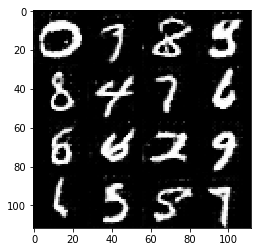

Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.8853


In [78]:
#TODO:
batch_size = 16
z_dim = 100
learning_rate = 0.005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

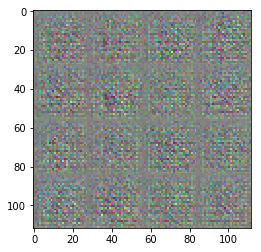

Epoch 0/1... Discriminator Loss: 9.8797... Generator Loss: 0.0001


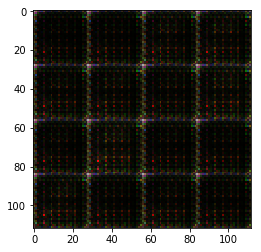

Epoch 0/1... Discriminator Loss: 2.1086... Generator Loss: 0.3868


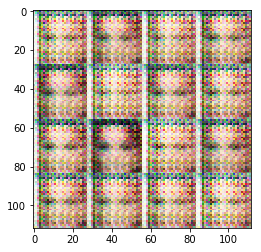

Epoch 0/1... Discriminator Loss: 1.8268... Generator Loss: 0.4744


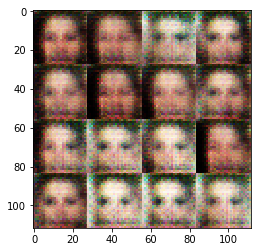

Epoch 0/1... Discriminator Loss: 1.5011... Generator Loss: 0.6684


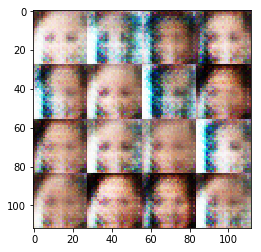

Epoch 0/1... Discriminator Loss: 1.7638... Generator Loss: 0.4416


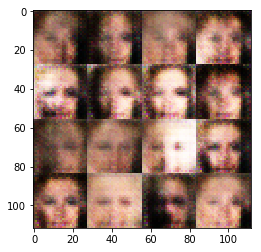

Epoch 0/1... Discriminator Loss: 1.4901... Generator Loss: 0.6363


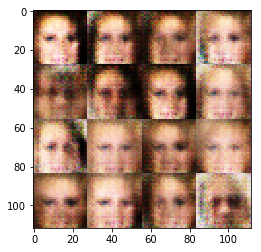

Epoch 0/1... Discriminator Loss: 1.9161... Generator Loss: 0.4536


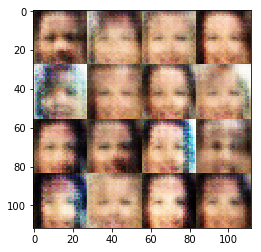

Epoch 0/1... Discriminator Loss: 1.5477... Generator Loss: 0.6396


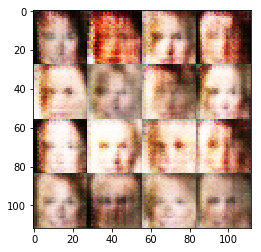

Epoch 0/1... Discriminator Loss: 1.8237... Generator Loss: 0.4526


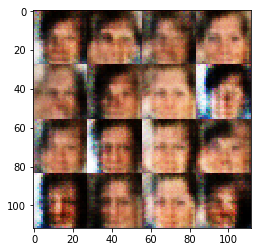

Epoch 0/1... Discriminator Loss: 1.6974... Generator Loss: 0.5395


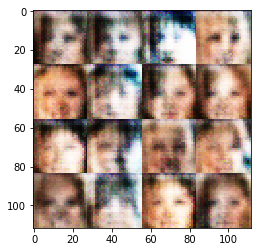

Epoch 0/1... Discriminator Loss: 1.5771... Generator Loss: 0.6092


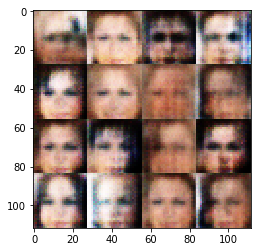

Epoch 0/1... Discriminator Loss: 1.4882... Generator Loss: 0.6714


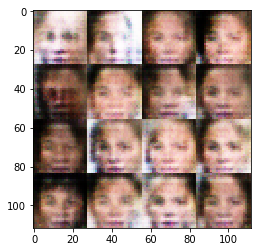

Epoch 0/1... Discriminator Loss: 1.5600... Generator Loss: 0.7111


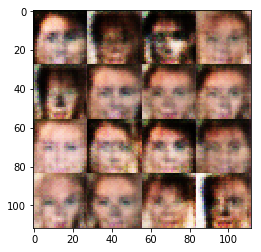

Epoch 0/1... Discriminator Loss: 1.5697... Generator Loss: 0.5884


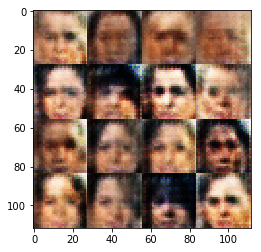

Epoch 0/1... Discriminator Loss: 1.5651... Generator Loss: 0.6229


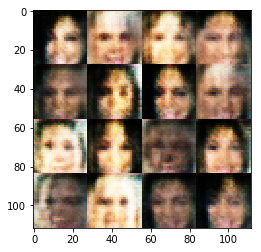

Epoch 0/1... Discriminator Loss: 1.6020... Generator Loss: 0.5890


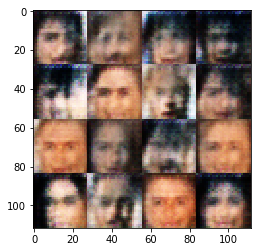

Epoch 0/1... Discriminator Loss: 1.6978... Generator Loss: 0.5380


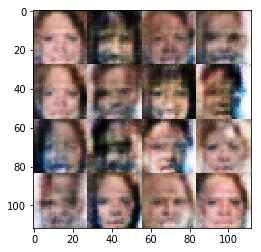

Epoch 0/1... Discriminator Loss: 1.6779... Generator Loss: 0.4806


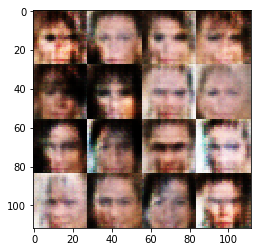

Epoch 0/1... Discriminator Loss: 1.4024... Generator Loss: 0.7551


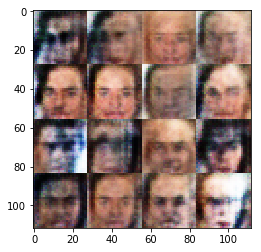

Epoch 0/1... Discriminator Loss: 1.7013... Generator Loss: 0.5757


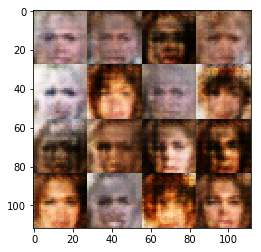

Epoch 0/1... Discriminator Loss: 1.6490... Generator Loss: 0.5325


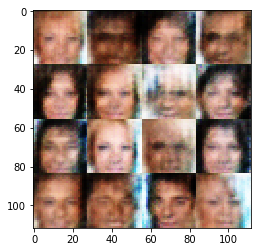

Epoch 0/1... Discriminator Loss: 1.5152... Generator Loss: 0.6758


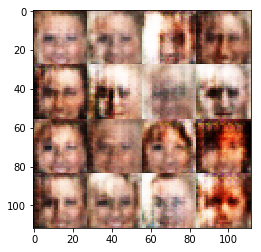

Epoch 0/1... Discriminator Loss: 1.5919... Generator Loss: 0.6179


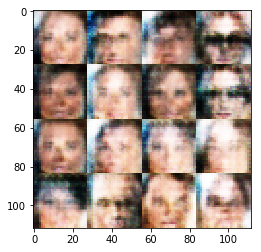

Epoch 0/1... Discriminator Loss: 1.6895... Generator Loss: 0.5608


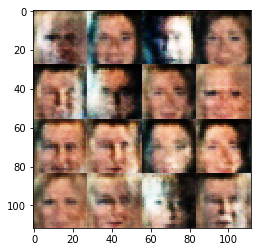

Epoch 0/1... Discriminator Loss: 1.8145... Generator Loss: 0.4797


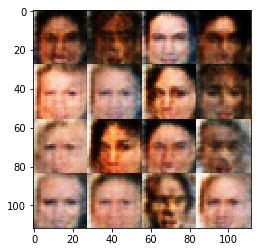

Epoch 0/1... Discriminator Loss: 1.4549... Generator Loss: 0.6863


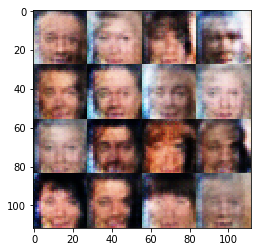

Epoch 0/1... Discriminator Loss: 1.5574... Generator Loss: 0.5681


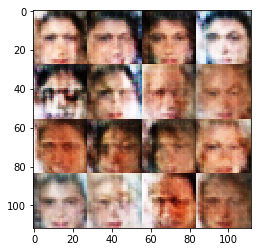

Epoch 0/1... Discriminator Loss: 1.5269... Generator Loss: 0.6107


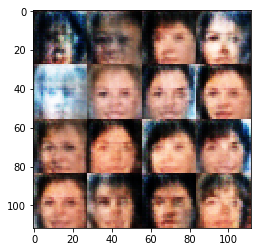

Epoch 0/1... Discriminator Loss: 1.6962... Generator Loss: 0.6056


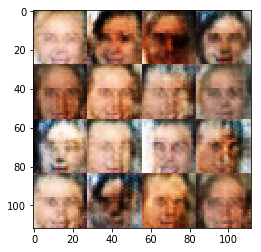

Epoch 0/1... Discriminator Loss: 1.5061... Generator Loss: 0.6133


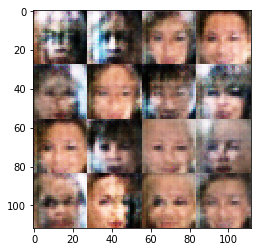

Epoch 0/1... Discriminator Loss: 1.4772... Generator Loss: 0.6358


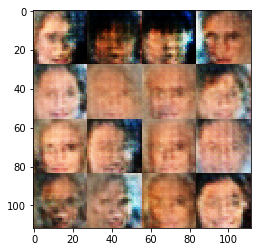

Epoch 0/1... Discriminator Loss: 1.6195... Generator Loss: 0.5473


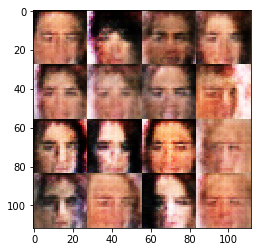

Epoch 0/1... Discriminator Loss: 1.5288... Generator Loss: 0.6228


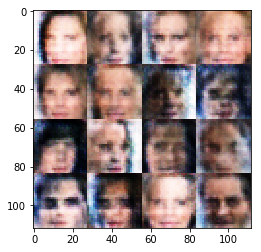

Epoch 0/1... Discriminator Loss: 1.5740... Generator Loss: 0.6372


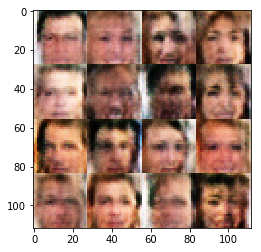

Epoch 0/1... Discriminator Loss: 1.5141... Generator Loss: 0.6371


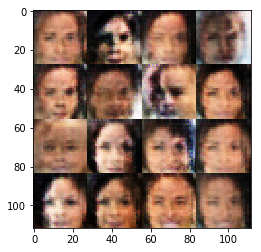

Epoch 0/1... Discriminator Loss: 1.5410... Generator Loss: 0.5974


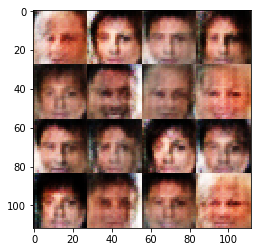

Epoch 0/1... Discriminator Loss: 1.7063... Generator Loss: 0.4732


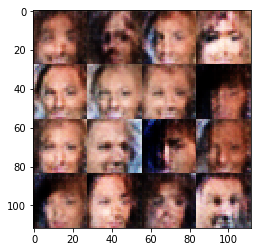

Epoch 0/1... Discriminator Loss: 1.5304... Generator Loss: 0.5643


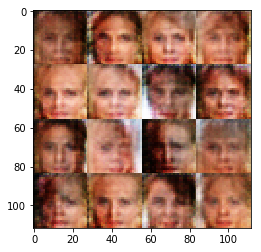

Epoch 0/1... Discriminator Loss: 1.6508... Generator Loss: 0.5397


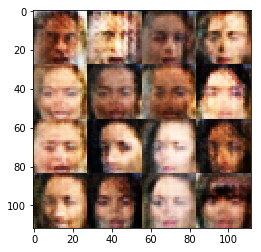

Epoch 0/1... Discriminator Loss: 1.5691... Generator Loss: 0.6132


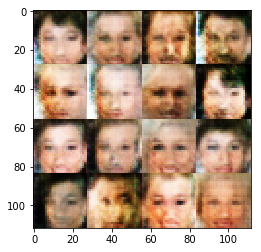

Epoch 0/1... Discriminator Loss: 1.5570... Generator Loss: 0.5791


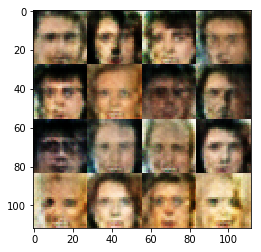

Epoch 0/1... Discriminator Loss: 1.4948... Generator Loss: 0.6242


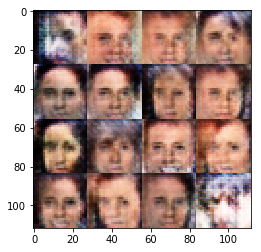

Epoch 0/1... Discriminator Loss: 1.6423... Generator Loss: 0.5070


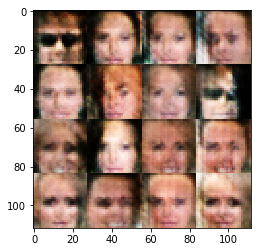

Epoch 0/1... Discriminator Loss: 1.5240... Generator Loss: 0.5633


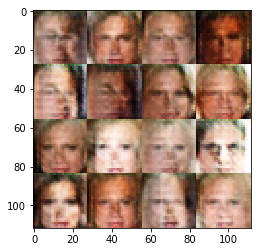

Epoch 0/1... Discriminator Loss: 1.4885... Generator Loss: 0.6723


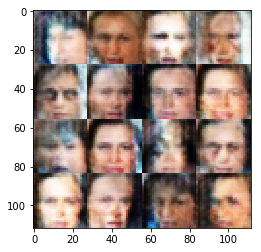

Epoch 0/1... Discriminator Loss: 1.6090... Generator Loss: 0.5799


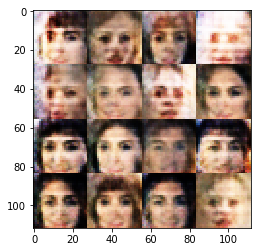

Epoch 0/1... Discriminator Loss: 1.5613... Generator Loss: 0.5842


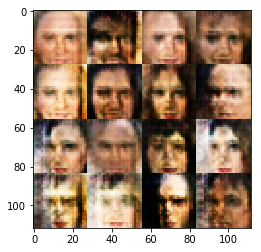

Epoch 0/1... Discriminator Loss: 1.5342... Generator Loss: 0.6056


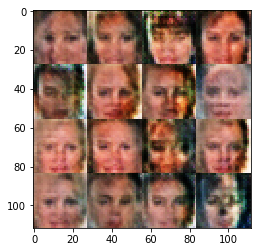

Epoch 0/1... Discriminator Loss: 1.5713... Generator Loss: 0.6097


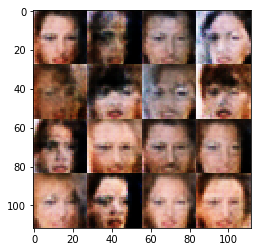

Epoch 0/1... Discriminator Loss: 1.4643... Generator Loss: 0.6869


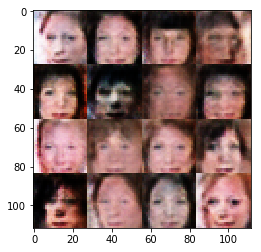

Epoch 0/1... Discriminator Loss: 1.5351... Generator Loss: 0.6722


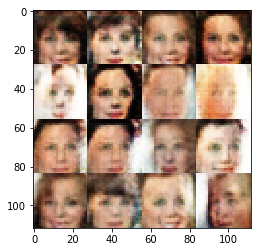

Epoch 0/1... Discriminator Loss: 1.5034... Generator Loss: 0.5425


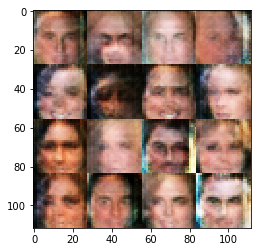

Epoch 0/1... Discriminator Loss: 1.3814... Generator Loss: 0.7424


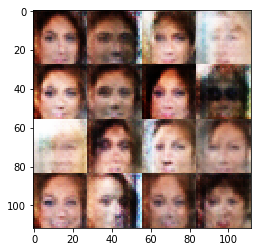

Epoch 0/1... Discriminator Loss: 1.4742... Generator Loss: 0.5958


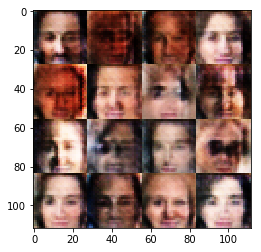

Epoch 0/1... Discriminator Loss: 1.5126... Generator Loss: 0.5581


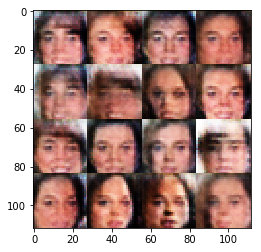

Epoch 0/1... Discriminator Loss: 1.4773... Generator Loss: 0.6680


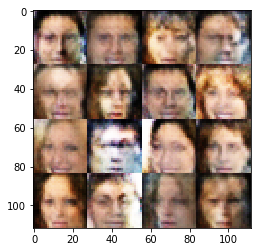

Epoch 0/1... Discriminator Loss: 1.4012... Generator Loss: 0.6620


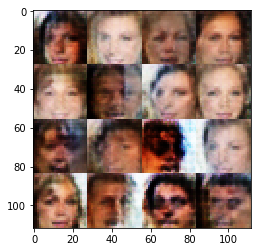

Epoch 0/1... Discriminator Loss: 1.5049... Generator Loss: 0.6576


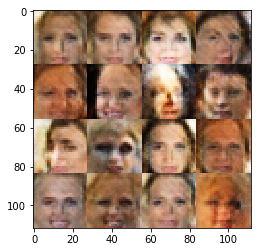

Epoch 0/1... Discriminator Loss: 1.4551... Generator Loss: 0.6239


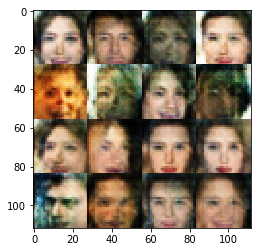

Epoch 0/1... Discriminator Loss: 1.5878... Generator Loss: 0.5196


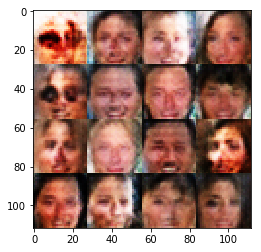

Epoch 0/1... Discriminator Loss: 1.4784... Generator Loss: 0.6237


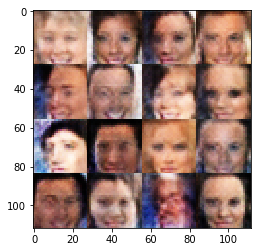

Epoch 0/1... Discriminator Loss: 1.5070... Generator Loss: 0.6108


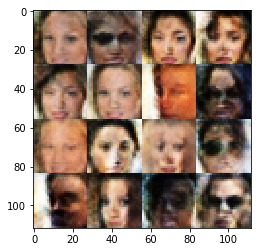

Epoch 0/1... Discriminator Loss: 1.5091... Generator Loss: 0.5785


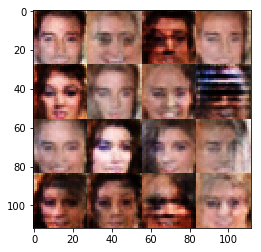

Epoch 0/1... Discriminator Loss: 1.4981... Generator Loss: 0.5861


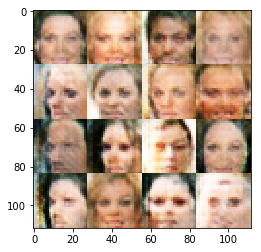

Epoch 0/1... Discriminator Loss: 1.4774... Generator Loss: 0.5580


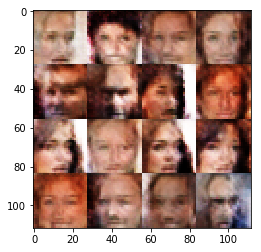

Epoch 0/1... Discriminator Loss: 1.5384... Generator Loss: 0.7106


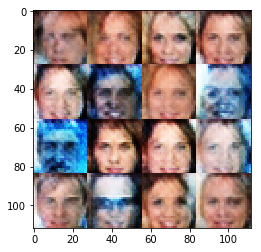

Epoch 0/1... Discriminator Loss: 1.4121... Generator Loss: 0.7205


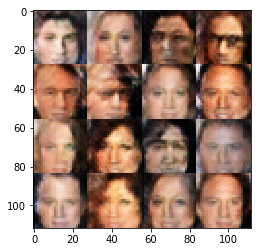

Epoch 0/1... Discriminator Loss: 1.3623... Generator Loss: 0.6747


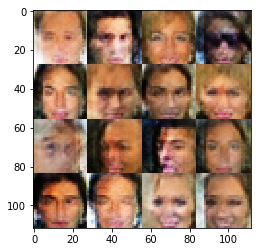

Epoch 0/1... Discriminator Loss: 1.4843... Generator Loss: 0.6813


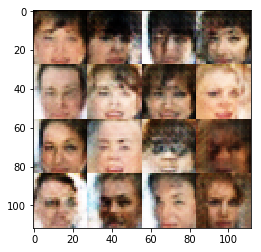

Epoch 0/1... Discriminator Loss: 1.5804... Generator Loss: 0.6267


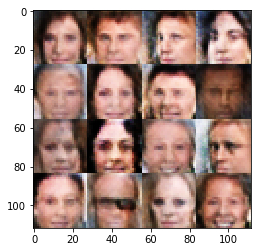

Epoch 0/1... Discriminator Loss: 1.5288... Generator Loss: 0.6308


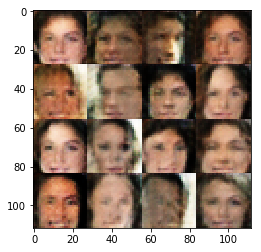

Epoch 0/1... Discriminator Loss: 1.4532... Generator Loss: 0.6450


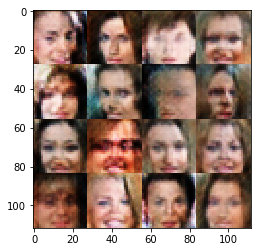

Epoch 0/1... Discriminator Loss: 1.3684... Generator Loss: 0.6681


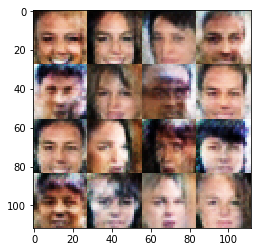

Epoch 0/1... Discriminator Loss: 1.6738... Generator Loss: 0.5361


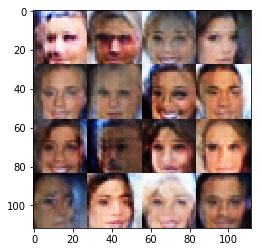

Epoch 0/1... Discriminator Loss: 1.3834... Generator Loss: 0.6963


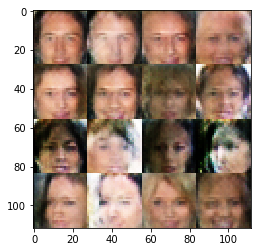

Epoch 0/1... Discriminator Loss: 1.4211... Generator Loss: 0.6272


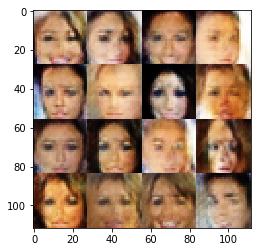

Epoch 0/1... Discriminator Loss: 1.4413... Generator Loss: 0.6182


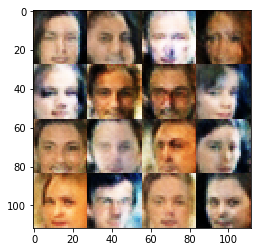

Epoch 0/1... Discriminator Loss: 1.4887... Generator Loss: 0.5687


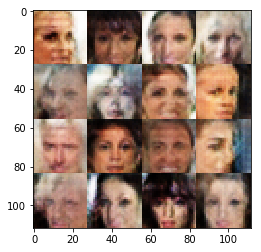

Epoch 0/1... Discriminator Loss: 1.6981... Generator Loss: 0.4714


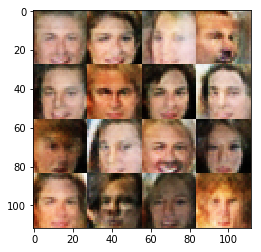

Epoch 0/1... Discriminator Loss: 1.4011... Generator Loss: 0.7470


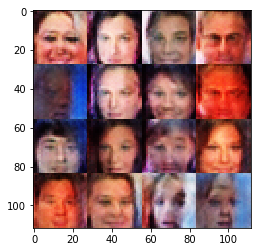

Epoch 0/1... Discriminator Loss: 1.5981... Generator Loss: 0.5701


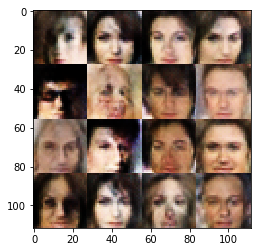

Epoch 0/1... Discriminator Loss: 1.2407... Generator Loss: 0.8206


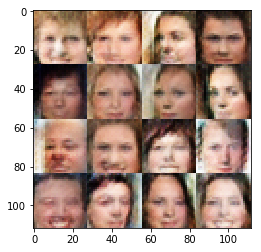

Epoch 0/1... Discriminator Loss: 1.4557... Generator Loss: 0.7303


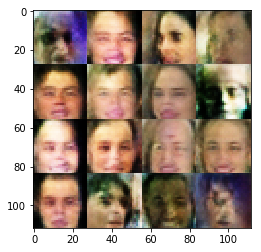

Epoch 0/1... Discriminator Loss: 1.4618... Generator Loss: 0.6335


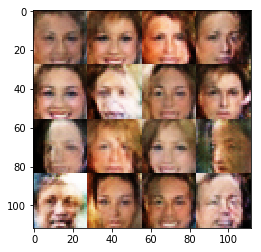

Epoch 0/1... Discriminator Loss: 1.5291... Generator Loss: 0.5872


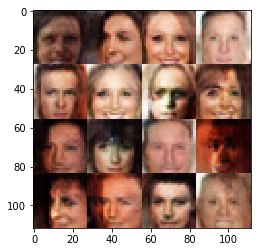

Epoch 0/1... Discriminator Loss: 1.5042... Generator Loss: 0.5277


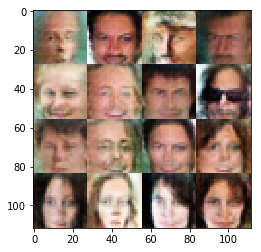

Epoch 0/1... Discriminator Loss: 1.4165... Generator Loss: 0.6625


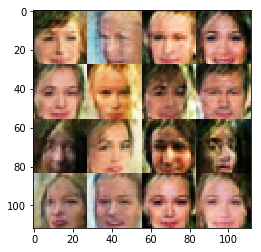

Epoch 0/1... Discriminator Loss: 1.4141... Generator Loss: 0.6310


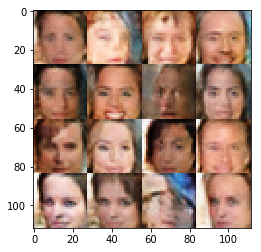

Epoch 0/1... Discriminator Loss: 1.5540... Generator Loss: 0.5669


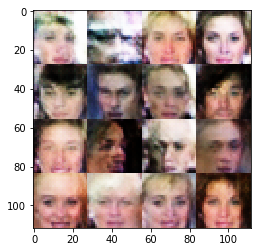

Epoch 0/1... Discriminator Loss: 1.4031... Generator Loss: 0.6027


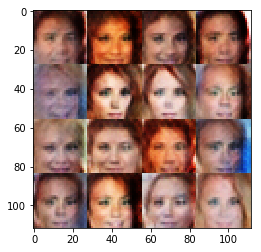

Epoch 0/1... Discriminator Loss: 1.6170... Generator Loss: 0.5025


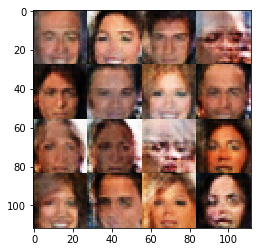

Epoch 0/1... Discriminator Loss: 1.4086... Generator Loss: 0.6141


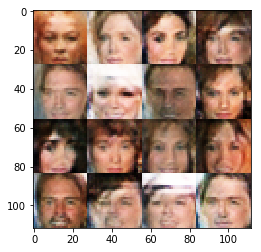

Epoch 0/1... Discriminator Loss: 1.6845... Generator Loss: 0.4742


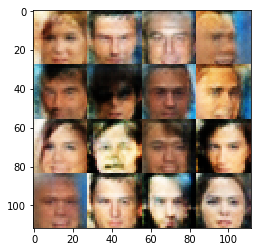

Epoch 0/1... Discriminator Loss: 1.5402... Generator Loss: 0.5127


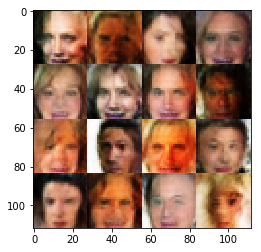

Epoch 0/1... Discriminator Loss: 1.6586... Generator Loss: 0.4736


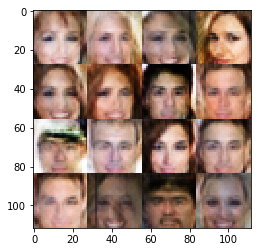

Epoch 0/1... Discriminator Loss: 1.6653... Generator Loss: 0.4207


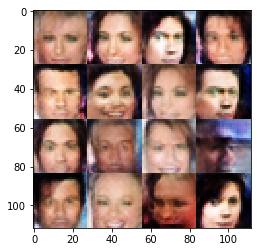

Epoch 0/1... Discriminator Loss: 1.5976... Generator Loss: 0.5539


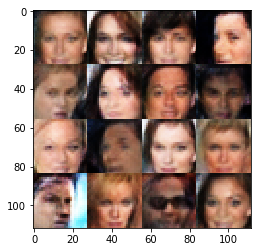

Epoch 0/1... Discriminator Loss: 1.3295... Generator Loss: 0.6985


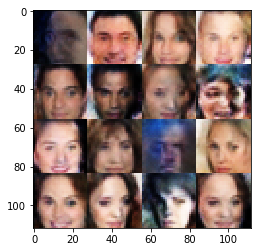

Epoch 0/1... Discriminator Loss: 1.5045... Generator Loss: 0.6438


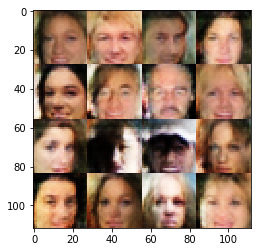

Epoch 0/1... Discriminator Loss: 1.5351... Generator Loss: 0.5368


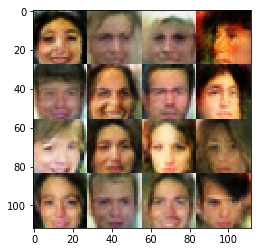

Epoch 0/1... Discriminator Loss: 1.6151... Generator Loss: 0.4921


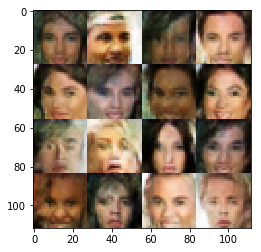

Epoch 0/1... Discriminator Loss: 1.3131... Generator Loss: 0.6788


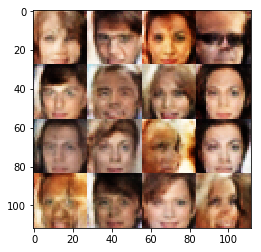

Epoch 0/1... Discriminator Loss: 1.6263... Generator Loss: 0.4625


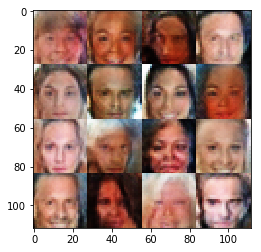

Epoch 0/1... Discriminator Loss: 1.5561... Generator Loss: 0.4519


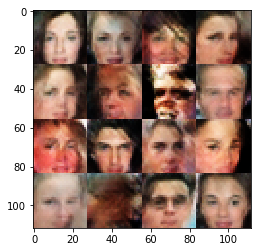

Epoch 0/1... Discriminator Loss: 1.5548... Generator Loss: 0.4963


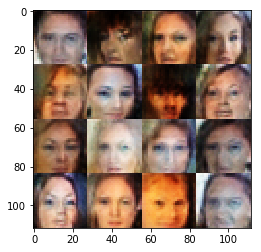

Epoch 0/1... Discriminator Loss: 1.5896... Generator Loss: 0.4756


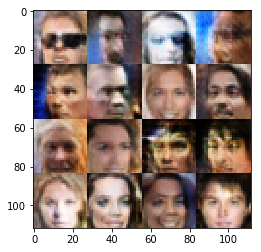

Epoch 0/1... Discriminator Loss: 1.5817... Generator Loss: 0.5390


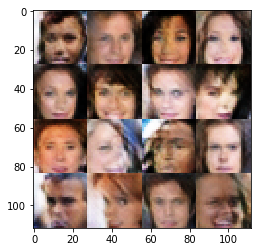

Epoch 0/1... Discriminator Loss: 1.5673... Generator Loss: 0.5707


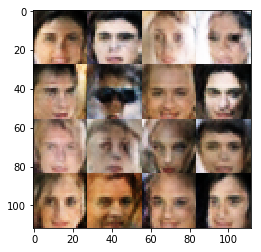

Epoch 0/1... Discriminator Loss: 1.5221... Generator Loss: 0.5679


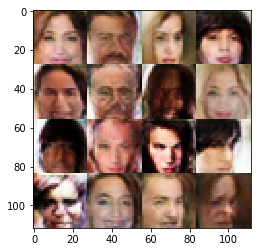

Epoch 0/1... Discriminator Loss: 1.5549... Generator Loss: 0.4610


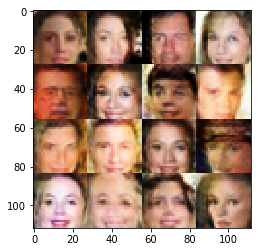

Epoch 0/1... Discriminator Loss: 1.5089... Generator Loss: 0.5458


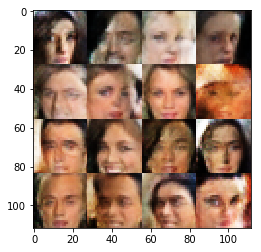

Epoch 0/1... Discriminator Loss: 1.7347... Generator Loss: 0.3592


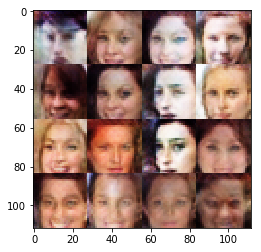

Epoch 0/1... Discriminator Loss: 1.5929... Generator Loss: 0.5044


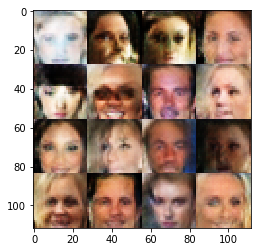

Epoch 0/1... Discriminator Loss: 1.6135... Generator Loss: 0.4762


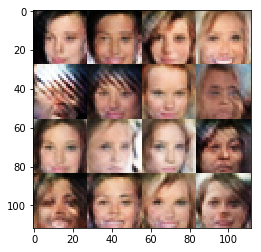

Epoch 0/1... Discriminator Loss: 1.8747... Generator Loss: 0.3511


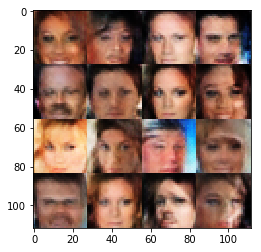

Epoch 0/1... Discriminator Loss: 1.7488... Generator Loss: 0.3951


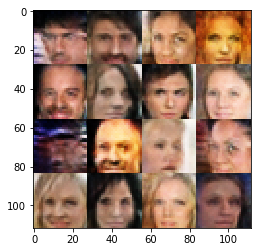

Epoch 0/1... Discriminator Loss: 1.4602... Generator Loss: 0.5151


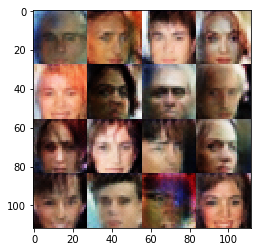

Epoch 0/1... Discriminator Loss: 1.4131... Generator Loss: 0.5839


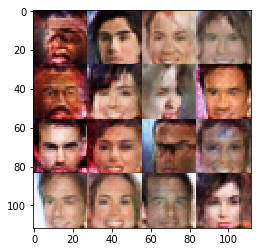

Epoch 0/1... Discriminator Loss: 1.5566... Generator Loss: 0.5060


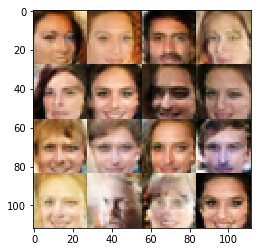

Epoch 0/1... Discriminator Loss: 1.5159... Generator Loss: 0.5248


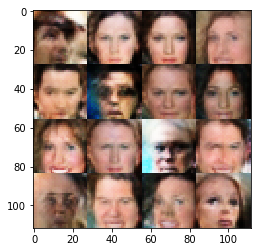

Epoch 0/1... Discriminator Loss: 1.7019... Generator Loss: 0.4792


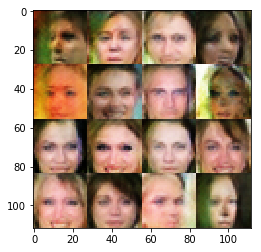

Epoch 0/1... Discriminator Loss: 1.5938... Generator Loss: 0.5745


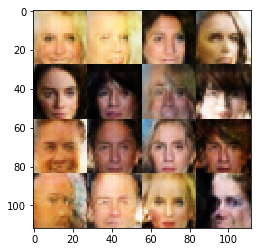

Epoch 0/1... Discriminator Loss: 1.5691... Generator Loss: 0.4409


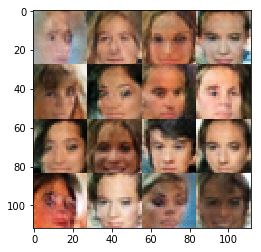

Epoch 0/1... Discriminator Loss: 1.7825... Generator Loss: 0.3662


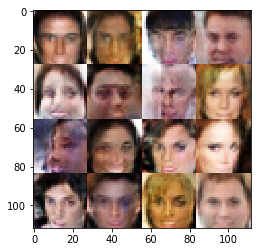

Epoch 0/1... Discriminator Loss: 1.5671... Generator Loss: 0.4647


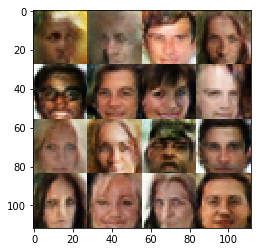

Epoch 0/1... Discriminator Loss: 1.7083... Generator Loss: 0.4081


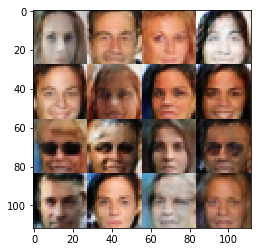

Epoch 0/1... Discriminator Loss: 1.7925... Generator Loss: 0.3679


In [79]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.